In [123]:
import numpy as np, pandas as pd
from ISLP import load_data
import seaborn as sns
from matplotlib import pyplot as plt
import ISLP
from ISLP import load_data
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError ,
    R2Score)
from sklearn.metrics import f1_score
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
import pytorch_lightning as L
from pytorch_lightning.loggers import CSVLogger
from torchvision.datasets import MNIST , CIFAR100
from IPython.display import clear_output
from torchvision.models import (resnet50 ,
    ResNet50_Weights)
from torchvision.transforms import (Resize ,
    Normalize ,
    CenterCrop ,
    ToTensor)
from ISLP.torch import (SimpleDataModule ,
    SimpleModule ,
    ErrorTracker ,
    rec_num_workers)
from ISLP.torch.imdb import (load_lookup ,
    load_tensor ,
    load_sparse ,
    load_sequential)
from glob import glob
import json
sns.set_palette("pastel")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [124]:
Default = load_data('Default').dropna()
D_Default = pd.get_dummies(Default, drop_first=True)
X = D_Default.drop('default_Yes', axis=1).to_numpy()
y = D_Default['default_Yes'].to_numpy().reshape(-1, 1)

In [125]:
X_temp , X_test , y_temp , y_test = train_test_split(X, y, test_size = 1/3, random_state = 42)
X_train , X_val , y_train , y_val = train_test_split(X_temp, y_temp, test_size = 1/5, random_state = 42)

In [126]:
scaler = StandardScaler().fit(X_train[:,:2])
X_train[:,:2] = scaler.transform(X_train[:,:2])
X_test[:,:2] = scaler.transform(X_test[:,:2])
X_val[:,:2] = scaler.transform(X_val[:,:2])

In [133]:
class DefaultModel(nn.Module):
    def __init__(self , input_size):
        super(DefaultModel , self).__init__ ()
        self.sequential = nn.Sequential(
            nn.Linear(input_size , 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1),
            nn.Sigmoid())
    def forward(self , x):
        return self.sequential(x) 

In [134]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
def_train = TensorDataset(X_train_t , y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
def_test = TensorDataset(X_test_t , y_test_t)

X_val_t = torch.tensor(X_val.astype(np.float32))
y_val_t = torch.tensor(y_val.astype(np.float32))
def_val = TensorDataset(X_val_t , y_val_t)

train_dataloader = DataLoader(def_train, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(def_test, batch_size=128, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(def_val, batch_size=128, shuffle=False, pin_memory=True)

In [135]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [136]:
class NN_Trainer:
    def __init__(self, train_dl, val_dl, model, loss_fn, optimizer, max_epoch, early_stop):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loss_array = []
        self.val_loss_array = []
        self.early_stop = early_stop
        
    def train(self):
        for epoch in range(1, self.max_epoch+1):
            self.model.train()
            epoch_loss = 0
            for batch, (X, y) in enumerate(self.train_dl):
                X,y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                # Compute prediction error
                pred = self.model(X)
                train_loss = self.loss_fn(pred, y)
                epoch_loss += train_loss.item()
        
                # Backpropagation
                train_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
            epoch_loss = epoch_loss/len(self.train_dl)
            val_loss = self.validation()
            self.train_loss_array.append(epoch_loss)
            self.val_loss_array.append(val_loss)
            if self.early_stop.early_stop(val_loss):             
                break
                
            if epoch%10 == 0:
                clear_output(wait=True)
                print(f"{epoch}/{self.max_epoch+1}")
                print(f"Train loss: {epoch_loss:>7f}")
                print(f"Val loss: {val_loss:>7f}")
        self.model.eval()

    def validation(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = 0
            for X, y in self.val_dl:
                X,y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                pred = self.model(X)
                val_loss += self.loss_fn(pred, y).item()
        return val_loss/len(self.val_dl)

In [137]:
def_model = DefaultModel(X_train.shape[1])
def_model.to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(def_model.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
max_epoch = 10000
trainer = NN_Trainer(train_dataloader, val_dataloader, def_model, loss_fn, optimizer, max_epoch, early_stopper)
trainer.train()

290/10001
Train loss: 0.132058
Val loss: 0.114992


<Axes: >

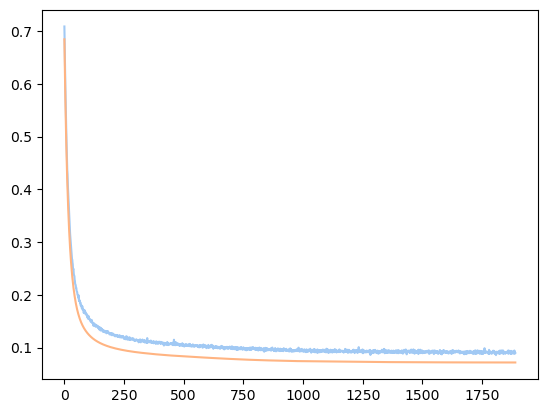

In [101]:
sns.lineplot(trainer.train_loss_array[1:])
sns.lineplot(trainer.val_loss_array[1:])

In [138]:
y_pred_nn = def_model(X_test_t.to(device)).cpu().detach().numpy()

In [139]:
logistic_model = LogisticRegressionCV().fit(X_train, y_train.ravel())
y_pred_logistic = logistic_model.predict_proba(X_test)

In [140]:
nn_fpr, nn_tpr, nn_thres = roc_curve(y_test, y_pred_nn)
logi_fpr, logi_tpr, logi_thres = roc_curve(y_test, y_pred_logistic[:,1])

<Axes: >

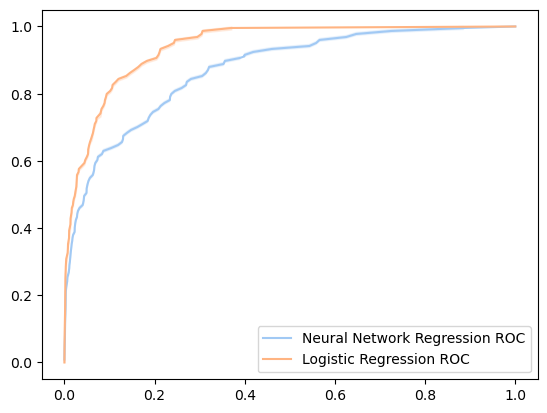

In [141]:
sns.lineplot(x=nn_fpr, y=nn_tpr, label='Neural Network Regression ROC')
sns.lineplot(x=logi_fpr, y=logi_tpr, label='Logistic Regression ROC')

In [142]:
print(classification_report(y_test, y_pred_nn > 0.2))

              precision    recall  f1-score   support

       False       0.97      1.00      0.98      3222
        True       0.67      0.02      0.03       112

    accuracy                           0.97      3334
   macro avg       0.82      0.51      0.51      3334
weighted avg       0.96      0.97      0.95      3334



In [143]:
print(classification_report(y_test, y_pred_logistic[:,1] > 0.2))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98      3222
        True       0.41      0.54      0.47       112

    accuracy                           0.96      3334
   macro avg       0.70      0.76      0.72      3334
weighted avg       0.96      0.96      0.96      3334

